### GraviGNN: Gravity Inversion using Graph Neural Networks

This notebook provides evaluation code for the **GraviGNN** model used for gravity anomaly inversion.

### Contents
- Import Libraries
- Hyperparameter Setup
- Model Architecture
- Loss Functions
- Dataset Loading
- Model Training
- Evaluation on Synthetic Data

### Import Required Libraries

This section imports all required Python libraries.

In [1]:

import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from collections import Counter
from sklearn.metrics import f1_score
import torch.nn.functional as F
import time
import h5py
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
plt.rc('font',family='Times New Roman', size=12)

In [2]:
import torch

torch.cuda.is_available()

True

### Training Hyperparameters

Defines core training parameters including:
- Number of epochs
- Learning rate
- Early stopping patience

In [3]:
# Deep network parameters
patience = 20
epochs = 180
tra_num = 10000
val_num = 1000
syn_num = 200
batch_size = 16
num_cell = 32
learning_rate = 4e-4
threshold = 1e-4
realdata_num = 1
start_fm = 32
total_num = tra_num + val_num
noise_levels = [0.02, 0.04]
density = [1000, 600]

# Ablation
noise_levels = [0.02, 0.1]

#### Model Architecture

Defines the neural network components used in GraviGNN.
This includes:
- Double convolution blocks
- Encoder-decoder structure
- Final prediction layer

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#############################
# Basic Modules
#############################

class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ELU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ELU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

#############################
# Graph Components
#############################

class GraphConv(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads=4, k=8):
        super(GraphConv, self).__init__()
        self.num_heads = num_heads
        self.k = k
        assert out_dim % num_heads == 0, "out_dim must be divisible by num_heads"
        self.head_dim = out_dim // num_heads
        self.linears = nn.ModuleList([nn.Linear(2 * in_dim, self.head_dim) for _ in range(num_heads)])

    def forward(self, x):
        B, N, D = x.shape
        dist = torch.cdist(x, x, p=2)
        diag = torch.eye(N, device=x.device).bool().unsqueeze(0)
        dist.masked_fill_(diag, float('inf'))
        
        effective_k = min(self.k, N - 1)
        knn_indices = torch.topk(-dist, k=effective_k, dim=-1).indices 

        batch_indices = torch.arange(B, device=x.device).view(B, 1, 1).expand(B, N, effective_k)
        neighbors = x[batch_indices, knn_indices] 

        agg, _ = torch.max(neighbors, dim=2) 
        concat_feat = torch.cat([x, agg], dim=-1) 

        head_outputs = [linear(concat_feat) for linear in self.linears]
        return torch.cat(head_outputs, dim=-1)

class ViGBlock(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads=4, k=8, ff_hidden_dim=None, dropout=0.1):
        super(ViGBlock, self).__init__()
        ff_hidden_dim = ff_hidden_dim or in_dim * 2
        self.proj_in = nn.Linear(in_dim, in_dim)
        self.graph_conv = GraphConv(in_dim, out_dim, num_heads=num_heads, k=k)
        self.proj_out = nn.Linear(out_dim, out_dim)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(out_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(out_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, out_dim)
        )
        self.norm2 = nn.LayerNorm(out_dim)

    def forward(self, x):
        # x shape: (B, N, D)
        shortcut = x
        x = self.proj_in(x)
        x = self.graph_conv(x)
        x = self.proj_out(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.norm1(x + shortcut)
        
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x

#############################
# Complete ViGUNet
#############################



class ViGUNet(nn.Module):
    def __init__(self, start_fm=32, num_heads=4, ff_hidden_dim=None, dropout=0.1, k=8):
        super(ViGUNet, self).__init__()
        
        # Encoder
        self.enc1 = double_conv(1, start_fm)
        self.vig1 = ViGBlock(start_fm, start_fm, num_heads, k, dropout=dropout)
        
        self.enc2 = double_conv(start_fm, start_fm*2)
        self.vig2 = ViGBlock(start_fm*2, start_fm*2, num_heads, k, dropout=dropout)
        
        self.enc3 = double_conv(start_fm*2, start_fm*4)
        self.vig3 = ViGBlock(start_fm*4, start_fm*4, num_heads, k, dropout=dropout)
        
        self.enc4 = double_conv(start_fm*4, start_fm*8)
        self.vig4 = ViGBlock(start_fm*8, start_fm*8, num_heads, k, dropout=dropout)
        
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck_conv = double_conv(start_fm*8, start_fm*16)
        self.bottleneck_vig = ViGBlock(start_fm*16, start_fm*16, num_heads, k, dropout=dropout)

        # Decoder
        self.up4 = nn.ConvTranspose2d(start_fm*16, start_fm*8, 2, 2)
        self.dec4 = double_conv(start_fm*16, start_fm*8)
        self.dvig4 = ViGBlock(start_fm*8, start_fm*8, num_heads, k, dropout=dropout)

        self.up3 = nn.ConvTranspose2d(start_fm*8, start_fm*4, 2, 2)
        self.dec3 = double_conv(start_fm*8, start_fm*4)
        self.dvig3 = ViGBlock(start_fm*4, start_fm*4, num_heads, k, dropout=dropout)

        self.up2 = nn.ConvTranspose2d(start_fm*4, start_fm*2, 2, 2)
        self.dec2 = double_conv(start_fm*4, start_fm*2)
        self.dvig2 = ViGBlock(start_fm*2, start_fm*2, num_heads, k, dropout=dropout)

        self.up1 = nn.ConvTranspose2d(start_fm*2, start_fm, 2, 2)
        self.dec1 = double_conv(start_fm*2, start_fm)
        self.dvig1 = ViGBlock(start_fm, start_fm, num_heads, k, dropout=dropout)

        # Output head for 2 classes and 16 slices (Total 32 channels)
        self.final_conv = nn.Conv2d(start_fm, 32, kernel_size=1)
        self.final_bn = nn.BatchNorm2d(32)

    def _apply_vig(self, x, vig_layer):
        B, C, H, W = x.shape
        x_flat = x.view(B, C, H * W).permute(0, 2, 1)
        x_vig = vig_layer(x_flat)
        return x_vig.permute(0, 2, 1).view(B, C, H, W)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e1 = self._apply_vig(e1, self.vig1)
        
        e2 = self.enc2(self.pool(e1))
        e2 = self._apply_vig(e2, self.vig2)
        
        e3 = self.enc3(self.pool(e2))
        e3 = self._apply_vig(e3, self.vig3)
        
        e4 = self.enc4(self.pool(e3))
        e4 = self._apply_vig(e4, self.vig4)

        # Bottleneck
        b = self.bottleneck_conv(self.pool(e4))
        b = self._apply_vig(b, self.bottleneck_vig)

        # Decoder
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d4 = self._apply_vig(d4, self.dvig4)

        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d3 = self._apply_vig(d3, self.dvig3)

        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d2 = self._apply_vig(d2, self.dvig2)

        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        d1 = self._apply_vig(d1, self.dvig1)

        # Final Reshape to (B, 2, 16, 32, 32)
        out = torch.sigmoid(self.final_bn(self.final_conv(d1)))
        return out.view(out.size(0), 2, 16, 32, 32)



### Loss Function

Implements Dice loss for segmentation-based density reconstruction.

In [5]:
#############################
# Loss Function
#############################

def dice_coef(pred, target, smooth=1e-5):
    """
    Computes Dice coefficient for multiclass tensors.
    """
    # Flatten across all spatial and class dimensions per batch element
    num = pred.size(0)
    p = pred.contiguous().view(num, -1)
    t = target.contiguous().view(num, -1)
    
    intersection = (p * t).sum(dim=1)
    cardinality = (p * p).sum(dim=1) + (t * t).sum(dim=1)
    
    dice = (2. * intersection + smooth) / (cardinality + smooth)
    return dice.mean()

def my_loss(pre_y, tru_y):
    # Loss is 1 - Dice Coefficient
    return 1 - dice_coef(pre_y, tru_y)

### Dataset Loading and Preprocessing

Loads gravity anomaly data and corresponding density models.
Prepares PyTorch Dataset and DataLoader objects.

In [6]:

dataFile = './tra&val/data{}.mat'
syn_dataFile = './syn/data{}.mat'

# For creating the forward response
with h5py.File(name='./G.mat', mode='r') as f:G = torch.Tensor(np.nan_to_num(f['G'][:])).T

### Visualization Utilities for Density Models and Gravity Anomalies

This block defines plotting functions used for visualizing inversion results:

- **Model() / plt_model():**  
  Generates 3D voxel representations of reconstructed density models with custom color mapping.

- **plt_m():**  
  Plots 1D density distributions (useful for model profile visualization).

- **plt_g():**  
  Displays gravity anomaly maps using filled contours with units in mGal.

- **plot_xoy():**  
  Plots horizontal slices (X–Y plane) of the 3D density model at selected depths.

- **colorma():**  
  Defines a custom colormap for density visualization.

These utilities are used to qualitatively assess:
- Spatial structure reconstruction
- Geological body continuity
- Gravity anomaly reproduction
- Depth-wise density variation


### Data Loading 

In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view((x.size(0),)+self.shape)
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self,images,train=True, masks=None):
        self.train = train
        self.images = images
        if self.train:
            self.masks = masks
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [8]:
x = []
y = []
for i in range(total_num):
    data = h5py.File(dataFile.format(i), 'r')
    m = data['con_m'][:2]
    m[0] = m[0]/density[0]
    m[1] = m[1]/density[1]
    d = data['d']
    d = np.nan_to_num(d)
    x.append(d.reshape(1, num_cell, num_cell))
    y.append(m.reshape(2, 16, num_cell, num_cell))
    
syn_x = []
syn_y = []
for i in range(syn_num):
    data = h5py.File(syn_dataFile.format(i), 'r')
    m = data['con_m'][:2]
    m[0] = m[0]/density[0]
    m[1] = m[1]/density[1]
    d = data['d']
    d = np.nan_to_num(d)
    syn_x.append(d.reshape(1, num_cell, num_cell))
    syn_y.append(m.reshape(2, 16, num_cell, num_cell))
    
tra_x = x[:tra_num]
tra_y = y[:tra_num]
val_x = x[-val_num:]
val_y = y[-val_num:]


In [9]:
print(np.shape(tra_x), np.shape(tra_y))
print(np.shape(val_x), np.shape(val_y))
print(np.shape(syn_x), np.shape(syn_y))

(10000, 1, 32, 32) (10000, 2, 16, 32, 32)
(1000, 1, 32, 32) (1000, 2, 16, 32, 32)
(200, 1, 32, 32) (200, 2, 16, 32, 32)


In [10]:
tra_idxs = list(range(len(tra_x)))
val_idxs = list(range(len(val_x)))
syn_idxs = list(range(len(syn_x)))
np.random.shuffle(tra_idxs)
np.random.shuffle(val_idxs)

In [11]:
tra = Dataset(np.array(tra_x).astype(np.float32)[tra_idxs], train=True, masks=np.array(tra_y).astype(np.float32)[tra_idxs])
val = Dataset(np.array(val_x).astype(np.float32)[val_idxs], train=True, masks=np.array(val_y).astype(np.float32)[val_idxs])
syn = Dataset(np.array(syn_x).astype(np.float32)[syn_idxs], train=True, masks=np.array(syn_y).astype(np.float32)[syn_idxs])
tra_loader = torch.utils.data.DataLoader(dataset=tra, batch_size=batch_size, shuffle=False, pin_memory=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=batch_size, shuffle=False, pin_memory=False)
syn_loader = torch.utils.data.DataLoader(dataset=syn, batch_size=batch_size, shuffle=False, pin_memory=False)

### Initialize the Model

In [13]:
model = ViGUNet(start_fm=32, num_heads=4, dropout=0.3, k=8)
model.cuda()

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Summarize the model with a sample input size (1, 32, 32)
summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
               ELU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
               ELU-4           [-1, 32, 32, 32]               0
       double_conv-5           [-1, 32, 32, 32]               0
            Linear-6             [-1, 1024, 32]           1,056
            Linear-7              [-1, 1024, 8]             520
            Linear-8              [-1, 1024, 8]             520
            Linear-9              [-1, 1024, 8]             520
           Linear-10              [-1, 1024, 8]             520
        GraphConv-11             [-1, 1024, 32]               0
           Linear-12             [-1, 1024, 32]           1,056
             ReLU-13             [-1, 1024, 32]               0
          Dropout-14             [-1, 1

### Training, Validation, and Testing Loop

This block performs the complete model training procedure:

- **Training phase:**  
  The model is set to training mode, performs forward propagation on training data, computes loss, backpropagates gradients, and updates parameters.

- **Validation phase:**  
  The model switches to evaluation mode. Validation loss is computed without gradient updates. Early stopping is checked based on validation loss stability.

- **Synthetic test phase:**  
  The model is evaluated on synthetic geological models to assess generalization performance.

- **Checkpointing:**  
  Model weights are saved at the end of every epoch.

In [14]:
import time
import torch
import numpy as np

# Configuration and tracking
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

mean_tra_losses = []
mean_val_losses = []
mean_syn_losses = []
val_data = []
syn_data = []

start = time.time()
epoch = 0

# The loop runs until epochs limit OR early stopping triggers
while epoch < epochs:
    tra_losses = []
    val_losses = []
    syn_losses = []
    
    # --- Training Phase ---
    model.train()
    for images, masks in tra_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = my_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        
        tra_losses.append(loss.item())

    # --- Validation Phase ---
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            v_loss = my_loss(outputs, masks)
            val_losses.append(v_loss.item())

    # --- Synthesis/Testing Phase ---
    with torch.no_grad():
        for images, masks in syn_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            s_loss = my_loss(outputs, masks)
            syn_losses.append(s_loss.item())

    # Compute mean losses for this epoch
    m_tra = np.mean(tra_losses)
    m_val = np.mean(val_losses)
    m_syn = np.mean(syn_losses)
    
    mean_tra_losses.append(m_tra)
    mean_val_losses.append(m_val)
    mean_syn_losses.append(m_syn)

    print(f'Epoch: {epoch+1}/{epochs}. Tra Loss: {m_tra:.4f}. Val Loss: {m_val:.4f}. Syn Loss: {m_syn:.4f}')

    # --- Save Model ---
    torch.save(model.state_dict(), 'multi_model_gravignn1.pth')
    
    # --- Early Stopping & Final Data Collection Logic ---
    # Trigger if we hit max epochs OR if improvement is below threshold over the patience window
    should_stop = False
    if epoch > patience:
        loss_diff = abs(mean_val_losses[-patience] - mean_val_losses[-1])
        if loss_diff < threshold:
            print(f"Early stopping triggered at epoch {epoch+1} (Loss diff: {loss_diff:.6f} < {threshold})")
            should_stop = True

    if should_stop or epoch == (epochs - 1):
        # Final data capture for visualization/analysis
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                val_data.append([model(images.to(device)).cpu(), masks, images])
            for images, masks in syn_loader:
                syn_data.append([model(images.to(device)).cpu(), masks, images])
        
        if should_stop:
            break

    epoch += 1

end = time.time()
print(f"Training completed in {(end - start):.2f} seconds.")

Epoch: 1/180. Tra Loss: 0.9031. Val Loss: 0.8820. Syn Loss: 0.8926
Epoch: 2/180. Tra Loss: 0.8613. Val Loss: 0.8346. Syn Loss: 0.8382
Epoch: 3/180. Tra Loss: 0.8129. Val Loss: 0.7740. Syn Loss: 0.8487
Epoch: 4/180. Tra Loss: 0.7472. Val Loss: 0.6810. Syn Loss: 0.8859
Epoch: 5/180. Tra Loss: 0.6533. Val Loss: 0.5334. Syn Loss: 0.8166
Epoch: 6/180. Tra Loss: 0.6138. Val Loss: 0.6047. Syn Loss: 0.6488
Epoch: 7/180. Tra Loss: 0.5621. Val Loss: 0.5418. Syn Loss: 0.5047
Epoch: 8/180. Tra Loss: 0.4935. Val Loss: 0.4671. Syn Loss: 0.3933
Epoch: 9/180. Tra Loss: 0.4433. Val Loss: 0.4346. Syn Loss: 0.3454
Epoch: 10/180. Tra Loss: 0.4079. Val Loss: 0.3864. Syn Loss: 0.3476
Epoch: 11/180. Tra Loss: 0.3781. Val Loss: 0.3608. Syn Loss: 0.2943
Epoch: 12/180. Tra Loss: 0.3533. Val Loss: 0.3444. Syn Loss: 0.2734
Epoch: 13/180. Tra Loss: 0.3347. Val Loss: 0.3253. Syn Loss: 0.2747
Epoch: 14/180. Tra Loss: 0.3228. Val Loss: 0.3129. Syn Loss: 0.2013
Epoch: 15/180. Tra Loss: 0.3125. Val Loss: 0.3042. Syn Lo

In [15]:
model_File = './multi_model_gravignn1.pth'

In [16]:
syn_data = []
model.load_state_dict(torch.load(model_File))
model.eval()
for images, masks in syn_loader:
    with torch.no_grad():
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        syn_data.extend([[outputs, masks, images]])  

In [17]:
import numpy as np

# Initialize lists
val_truth = []
val_predict = [] 
val_truth_d = []

# Process Validation Data
# We iterate directly over the list 'val_data' to avoid the ValueError
for batch in val_data:
    # batch[0] = outputs, batch[1] = masks, batch[2] = images
    preds, masks, imgs = batch
    
    # Iterate through each sample in the batch
    for j in masks:
        # Reshape to (2, 16384) to flatten spatial/depth dims but keep class dim
        val_truth.append(j.detach().cpu().numpy().reshape(2, -1))
        
    for j in preds:
        val_predict.append(j.detach().cpu().numpy().reshape(2, -1))
        
    for j in imgs:
        # Reshape to (1024,) for flattened input representation
        val_truth_d.append(j.detach().cpu().numpy().reshape(-1))

# Process Synthetic Data
syn_truth = []
syn_predict = []
syn_truth_d = []

for batch in syn_data:
    preds, masks, imgs = batch
    
    for j in masks:
        syn_truth.append(j.detach().cpu().numpy().reshape(2, -1))
        
    for j in preds:
        syn_predict.append(j.detach().cpu().numpy().reshape(2, -1))
        
    for j in imgs:
        syn_truth_d.append(j.detach().cpu().numpy().reshape(-1))

# Convert final lists to numpy arrays for analysis
val_truth = np.array(val_truth)
val_predict = np.array(val_predict)
val_truth_d = np.array(val_truth_d)

syn_truth = np.array(syn_truth)
syn_predict = np.array(syn_predict)
syn_truth_d = np.array(syn_truth_d)

print(f"Shapes check - Val Truth: {val_truth.shape}, Val Predict: {val_predict.shape}")

Shapes check - Val Truth: (1000, 2, 16384), Val Predict: (1000, 2, 16384)


In [18]:
print(val_truth[0].shape)
print(val_predict[0].shape)
print(val_truth_d[0].shape)

print(syn_truth[0].shape)
print(syn_predict[0].shape)
print(syn_truth_d[0].shape)

(2, 16384)
(2, 16384)
(1024,)
(2, 16384)
(2, 16384)
(1024,)


## Qualitative Comparison: Ground Truth vs Predicted Model

This block visualizes a selected validation example to compare:

1️⃣ **Gravity Anomaly Maps**
- Computes predicted gravity anomaly using forward operator \( G \).
- Plots true and predicted gravity fields side-by-side.
- Uses consistent contour levels for fair comparison.

2️⃣ **3D Density Model Visualization**
- Reshapes predicted density into 3D grid.
- Applies thresholding for voxel rendering.
- Displays reconstructed geological structure.

3️⃣ **Depth Slice Comparison**
- Plots horizontal slice (X–Y plane) at selected depth.
- Compares true and predicted density distributions.

These visualizations help assess:
- Forward consistency (density → gravity)
- Structural reconstruction quality
- Depth-wise geological accuracy


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
from matplotlib.cm import ScalarMappable

# =========================================================
# GLOBAL SETTINGS
# =========================================================
TEXT_SIZE = 16 
FIG_SIZE_2D = (6, 5) 
FIG_SIZE_3D = (6, 5)

# Grid Logic for 100m intervals: 1600m total / 32 units = 50m per unit. 
# A line every 100m requires a tick every 2 units.
GRID_TICKS_XY = np.arange(0, 33, 2) 
GRID_TICKS_Z = np.arange(0, 17, 2)

plt.rcParams.update({
    'font.size': TEXT_SIZE,
    'axes.titlesize': TEXT_SIZE,
    'axes.labelsize': TEXT_SIZE,
    'xtick.labelsize': TEXT_SIZE,
    'ytick.labelsize': TEXT_SIZE,
    'legend.fontsize': TEXT_SIZE,
    'figure.titlesize': TEXT_SIZE
})

def colorma():
    """Indexed colormap for density slices."""
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", 
             "#D3F821", "green", "#FF9D00", "#F03A00", "#E10000"] 
    return colors.ListedColormap(cdict)

# =========================================================
# 2D GRAVITY PLOT (NO GRID)
# =========================================================
def plt_g(g, my_levels, ax=None, title=""):
    """
    Standard rectangular colorbar version of gravity function.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3))
    
    # Discrete color tuple for gravity
    color = ('#00008F', '#0030FF', '#10FFEF', '#DFFF20', '#FF5000', '#800000')
    cmap = colors.ListedColormap(color)
    
    # Ensure non-negative for visualization
    g_vis = np.where(g > 0, g, 0)
    
    # cs initialization (No 'extend' to keep colorbar rectangular)
    cs = ax.contourf(g_vis, my_levels, cmap=cmap)
    ax.contour(cs, colors='k', linewidths=0.7)
    
    # Colorbar addition
    cbar = plt.colorbar(cs, ax=ax, shrink=1, aspect=25)

    # 🔹 UNIT AT TOP
    cbar.ax.set_title(r'mGal', pad=6)

    # Formatter and tick styling
    cbar.formatter = FormatStrFormatter('%.1f')
    cbar.update_ticks()
    cbar.ax.tick_params(labelsize=TEXT_SIZE)

    # Axis Labels and Ticks (0 to 1600m)
    ax.set_xticks(np.arange(0, 32, 7.75))
    ax.set_xticklabels(('0', '400', '800', '1200', '1600'))
    ax.set_xlabel('Easting (m)')
    
    ax.set_yticks(np.arange(0, 32, 7.75))
    ax.set_yticklabels(('0', '400', '800', '1200', '1600'))
    ax.set_ylabel('Northing (m)')
    
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    if title:
        ax.set_title(title)

# =========================================================
# 2D SLICE PLOT (XOY) - 100m GRID
# =========================================================
def plot_xoy(model, index, ax=None, title=""):
    if ax is None:
        fig, ax = plt.subplots(figsize=FIG_SIZE_2D)
    
    combined = np.around(model[0], decimals=1) + 0.6 * np.around(model[1], decimals=1)
    im = ax.imshow(combined[index], cmap=colorma(), origin='lower')
    # ax.invert_yaxis()
    
    # 100m Ticks (every 2 index units)
    ax.set_xticks(GRID_TICKS_XY)
    ax.set_yticks(GRID_TICKS_XY)
    
    # Labels only every 400m for readability
    ax.set_xticklabels([str(int(x*50)) if x % 8 == 0 else '' for x in GRID_TICKS_XY])
    ax.set_yticklabels([str(int(y*50)) if y % 8 == 0 else '' for y in GRID_TICKS_XY])

    ax.grid(visible=True, color='black', linestyle='-', linewidth=0.4, alpha=0.4)
    ax.set_axisbelow(False) 

    cbar = plt.colorbar(im, ax=ax, shrink=0.95, aspect=25)
    cbar.ax.set_title(r'g·cm$^{-3}$', fontsize=TEXT_SIZE, pad=10)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    if title: ax.set_title(title)

# =========================================================
# 3D VOXEL MODELS - 100m GRID
# =========================================================
def plt_model_base(model, facecolors, title="", fname=None):
    fig = plt.figure(figsize=FIG_SIZE_3D)
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(model, facecolors=facecolors, edgecolors='w', linewidth=0.5)
    
    # 100m Ticks
    ax.set_xticks(GRID_TICKS_XY)
    ax.set_yticks(GRID_TICKS_XY)
    ax.set_zticks(GRID_TICKS_Z)
    
    # Labels only every 400m
    ax.set_xticklabels([str(int(x*50)) if x % 8 == 0 else '' for x in GRID_TICKS_XY])
    ax.set_yticklabels([str(int(y*50)) if y % 8 == 0 else '' for y in GRID_TICKS_XY])
    ax.set_zticklabels([str(int(z*50)) if z % 8 == 0 else '' for z in GRID_TICKS_Z])
    
    ax.set_xlabel('Easting (m)', labelpad=5)
    ax.set_ylabel('Northing (m)', labelpad=5)
    ax.set_zlabel('Depth (m)', labelpad=2)
    ax.invert_zaxis()
    
    # Enable 100m grid for 3D perspective
    ax.xaxis._axinfo["grid"].update({"linewidth": 0.4, "linestyle": "-", "color": "gray", "alpha": 0.4})
    ax.yaxis._axinfo["grid"].update({"linewidth": 0.4, "linestyle": "-", "color": "gray", "alpha": 0.4})
    ax.zaxis._axinfo["grid"].update({"linewidth": 0.4, "linestyle": "-", "color": "gray", "alpha": 0.4})

    sm = ScalarMappable(cmap=colorma(), norm=colors.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.75, aspect=30, pad=0.1)
    cbar.ax.set_title(r'g·cm$^{-3}$', fontsize=TEXT_SIZE, pad=10)
    
    if title: ax.set_title(title)
    if fname: plt.savefig(f"{fname}.png", dpi=300, bbox_inches='tight')
    plt.show()

def Model(m, w, title="", fname=None):
    m1 = m[0].transpose(2, 1, 0) 
    m2 = m[1].transpose(2, 1, 0)
    L, W, H = m1.shape
    c1 = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "green", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    c2 = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "green"]
    
    model_mask = np.zeros(m1.shape, dtype=bool)
    color = np.empty(m1.shape, dtype=object)
    
    for i in range(L):
        for j in range(W):
            for k in range(H):
                if m1[i,j,k] >= w:
                    idx = int(min(round(10*m1[i,j,k])-1, 9))
                    color[i,j,k] = c1[idx]
                    model_mask[i,j,k] = True
                elif m2[i,j,k] >= w:
                    idx = int(min(round(6*m2[i,j,k])-1, 5))
                    color[i,j,k] = c2[idx]
                    model_mask[i,j,k] = True
                    
    plt_model_base(model_mask, color, title=title, fname=fname)

<Figure size 600x500 with 0 Axes>

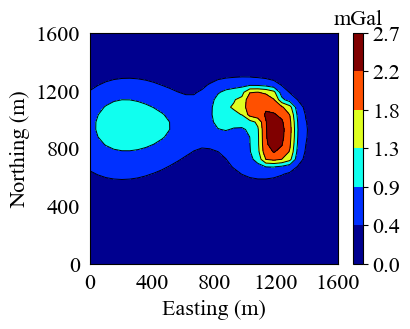

<Figure size 600x500 with 0 Axes>

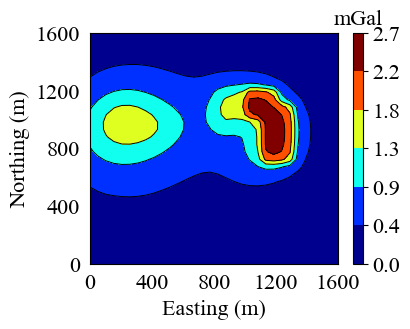

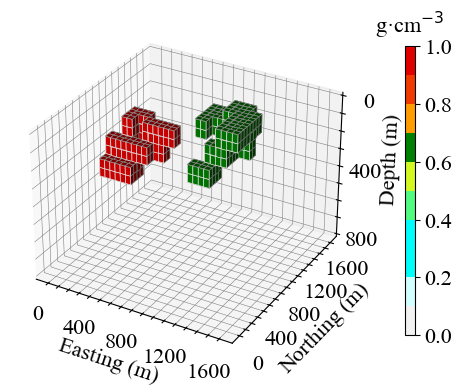

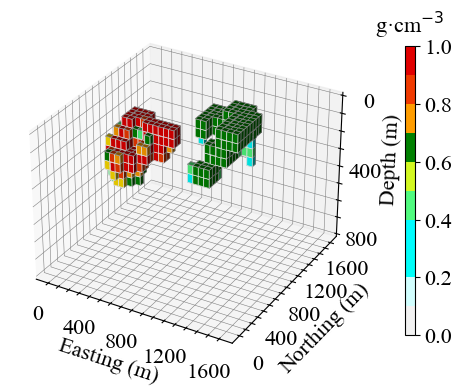

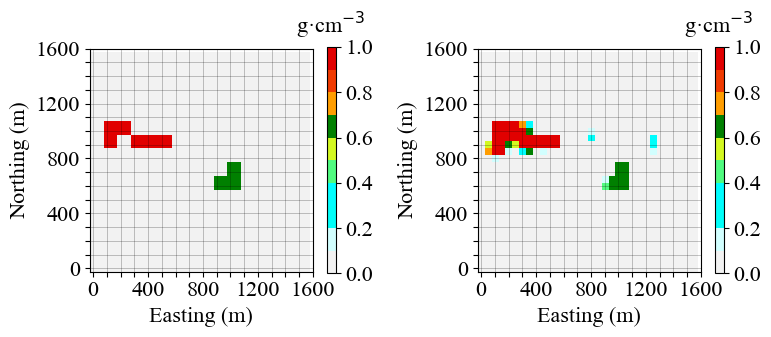

In [60]:
# --- Configuration ---
idx = 103
slice_idx = 4
num_cell = 32
rho1, rho2 = 1000, 600 

# 1. Prepare Data
m1_data = val_truth[idx].reshape(2, 16, num_cell, num_cell) 
m2_data = val_predict[idx].reshape(2, 16, num_cell, num_cell)
g_original = val_truth_d[idx].reshape(num_cell, num_cell)

# 2. Forward Calculation (Inverted Gravity)
# Mass = (Class 1 * 1000) + (Class 2 * 600)
m2_phys = (m2_data[0] * rho1 + m2_data[1] * rho2).flatten().reshape(-1, 1)
pre_g = np.array(np.asmatrix(G) * np.asmatrix(m2_phys)).reshape(num_cell, num_cell)

# 3. Discrete Levels for Gravity
my_levels = np.linspace(0., 1.1 * round(g_original.max(), 2), 7)

# --- SAVE INDIVIDUAL PLOTS ---

# 1. Original Gravity
plt.figure(figsize=(6, 5))
plt_g(g_original, my_levels, title="") 
plt.savefig(f"Original_Gravity_{idx}.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Inverted Gravity
plt.figure(figsize=(6, 5))
plt_g(pre_g, my_levels, title="") 
plt.savefig(f"Inverted_Gravity_{idx}.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. 3D Models
Model(m1_data, w=0.5, title="", fname=f"Original_Structure_3D_{idx}") 
Model(m2_data, w=0.5, title="", fname=f"Predicted_Structure_3D_{idx}") 

# 4. Comparative Slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
plot_xoy(m1_data, index=slice_idx, ax=ax1, title="") 
plot_xoy(m2_data, index=slice_idx, ax=ax2, title="") 
plt.tight_layout()
plt.savefig(f"Comparison_Slices_{idx}.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 600x500 with 0 Axes>

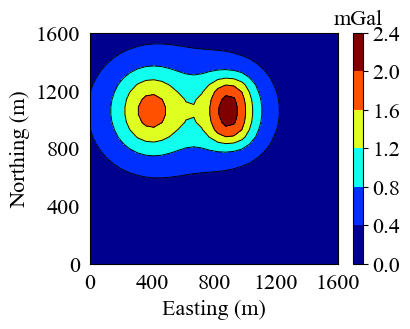

<Figure size 600x500 with 0 Axes>

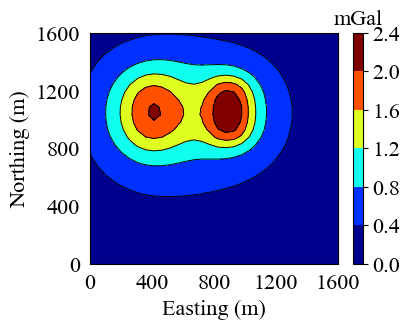

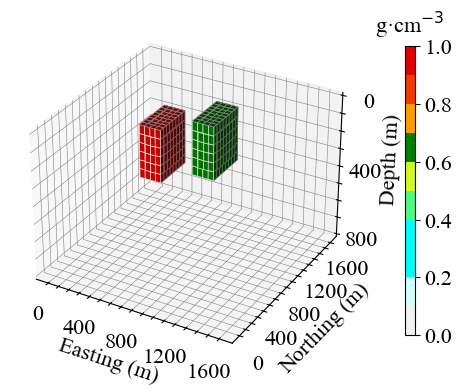

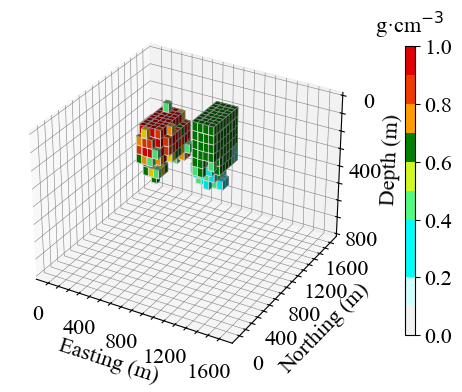

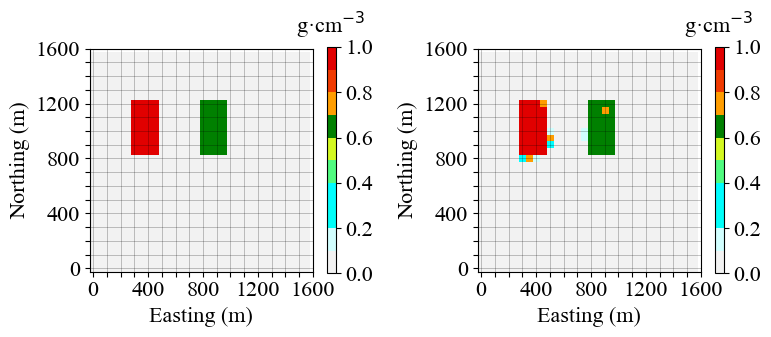

In [68]:
# --- Configuration ---
idx = 102
slice_idx = 3
num_cell = 32
rho1, rho2 = 1000, 600 

# 1. Prepare Data
m1_data = syn_truth[idx].reshape(2, 16, num_cell, num_cell) 
m2_data = syn_predict[idx].reshape(2, 16, num_cell, num_cell)
g_original = syn_truth_d[idx].reshape(num_cell, num_cell)

# 2. Forward Calculation (Inverted Gravity)
# Mass = (Class 1 * 1000) + (Class 2 * 600)
m2_phys = (m2_data[0] * rho1 + m2_data[1] * rho2).flatten().reshape(-1, 1)
pre_g = np.array(np.asmatrix(G) * np.asmatrix(m2_phys)).reshape(num_cell, num_cell)

# 3. Discrete Levels for Gravity
my_levels = np.linspace(0., 1.1 * round(g_original.max(), 2), 7)

# --- SAVE INDIVIDUAL PLOTS ---

# 1. Original Gravity
plt.figure(figsize=(6, 5))
plt_g(g_original, my_levels, title="") 
plt.savefig(f"Original_Gravity_{idx}.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Inverted Gravity
plt.figure(figsize=(6, 5))
plt_g(pre_g, my_levels, title="") 
plt.savefig(f"Inverted_Gravity_{idx}.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. 3D Models
Model(m1_data, w=0.5, title="", fname=f"Original_Structure_3D_{idx}") 
Model(m2_data, w=0.5, title="", fname=f"Predicted_Structure_3D_{idx}") 

# 4. Comparative Slices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
plot_xoy(m1_data, index=slice_idx, ax=ax1, title="") 
plot_xoy(m2_data, index=slice_idx, ax=ax2, title="") 
plt.tight_layout()
plt.savefig(f"Comparison_Slices_{idx}.png", dpi=300, bbox_inches='tight')
plt.show()